In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

source1: https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/
<br>
source2: https://www.kaggle.com/vingkan/multi-armed-bandit/notebook#Multi-Armed-Bandit

problem: Suppose an advertising company is running 10 different ads targeted towards a similar set of population on a webpage. We have results for which ads were clicked by a user. Each column index represents a different ad. We have a 1 if the ad was clicked by a user, and 0 if it was not.

In [19]:
path = "C:\\Users\\Srivatsa\\Desktop\\Renforcement_Learning\\k-arm bandit\\"

In [20]:
dataset = pd.read_csv(path+"Ads_Optimisation.csv")
print(dataset.shape)

(10000, 10)


So, there are 10000 time steps here

In [21]:
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

First, we will try a random selection technique, where we randomly select any ad and show it to the user. If the user clicks the ad, we get paid and if not, there is no profit.

In [22]:
import random

In [23]:
# Implementing Random Selection

N = 10000
d = 10
ads_selected = []
total_reward = 0

for n in range(0, N):
    ad = random.randrange(d)
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    total_reward += reward

In [24]:
print("Total reward is", total_reward)

Total reward is 1275


In [25]:
pd.Series(ads_selected).head(1500).value_counts(normalize = True)

3    0.110000
2    0.107333
4    0.106000
1    0.100667
9    0.100000
7    0.100000
0    0.097333
6    0.094000
5    0.092667
8    0.092000
dtype: float64

Upper Confidence Bound algorithm

In [26]:
# N=10000
# d=10
# ads_selected=[] #To finally know which ads were selected
# numbers_of_selections = [0] * d #
# sums_of_reward = [0] * d
# total_reward = 0
# c=2

# for n in range(0, N):
#     ad = 0
#     max_upper_bound = 0
#     for i in range(0, d):
#         if numbers_of_selections[i] > 0:
#             average_reward = sums_of_reward[i]/numbers_of_selections[i]
#             delta_i = c * np.sqrt(np.log(n+1))/numbers_of_selections[i]
#             upper_bound = average_reward + delta_i
#         else:
#             upper_bound = 1e400
#         if upper_bound > max_upper_bound:
#             max_upper_bound = upper_bound
#             ad = i
#         ads_selected.append(ad)
#         numbers_of_selections[ad] += 1
#         reward = dataset.values[n, ad]
#         sums_of_reward[ad] += reward
#         total_reward += reward             

<h1>Bandit Algorithms Classes</h1>

In [ ]:
class Bandit:
    """
    The basic functions of k-arm bandit incorporated:
            
        update_estimate: Updates the value estimates for an action and its action count.
        
        exploit: return the index of the current best action
        
        clear_learning: clears the learnt value estimates for actions        
    """
    def __init__(self, true_action_values, initial=0, random_state=None):
        self.true_action_values = true_action_values
        if len(self.true_action_values) < 1:
            raise ValueError("Array-like `true_action_values` must contain at least one value.")
        self.value_estimates = np.zeros(len(self.true_action_values))
        self.action_counts = np.zeros(len(self.true_action_values))
        self.initial = initial
        np.random.seed(random_state)
    
    # updates the value estimate for an action and its action count 
    def update_estimate(self, index, value_estimate):
        self.value_estimates[index] += value_estimate
        self.action_counts[index] += 1
        
    #get the best estimate
    def exploit(self):
        zero = 1e-10
        mean_estimates = self.value_estimates/(self.action_counts + zero)
        best_index = np.argmax(mean_estimates)
        return best_index
    
    #clear the learn value estimates and reset self.best 
    def clear_learning(self):
        self.best = self.initial
        self.value_estimates = np.zeros(len(self.true_action_values))
    


In [191]:
class EpsilonGreedyBandit(Bandit):
    """
        e_greedy_exploit: Will choose to explore or exploit and returns the reward and 
        index of choosen action
        
        get_epsilon: returns the epsilon value
    """
    def __init__(self, *args, epsilon=0.2, **kwargs):
        if epsilon < 0:
            raise ValueError("Probability of exploration cannot be negative")
        else:
            self.epsilon = epsilon
            super().__init__(*args, **kwargs)
    
    def get_epsilon(self):
        return self.epsilon
    
    #Choose to explore or exploit and then return the index and the reward for the choosen action
    def e_greedy_exploit(self):
        if np.random.ranf() < self.get_epsilon():
            #Explore
            index = np.random.randint(0, len(self.true_action_values))
            return index, self.true_action_values[index]
        else:
            #Exploit
            index = self.exploit()
            return index, self.true_action_values[index]
        

In [192]:
class EpsilonFirstBandit(EpsilonGreedyBandit):

    """
        The exploration period lasts for the first epsilon * trials turns
    """
    def __init__(self, *args, trials=100, **kwargs):
        if trials < 0:
            raise ValueError("Numerical trials cannot be negative")
        else:
            self.trials = trials
            super().__init__(*args, **kwargs)
            
    def get_epsilon(self):
        end_exploration = self.epsilon * self.trials
        total_action_count = self.action_counts.sum()
        if total_action_count < end_exploration:
            return 1
        return 0
    

In [193]:
class EpsilonDecayBandit(EpsilonGreedyBandit):
    
    """
        The exploration rate on each turn is epsilon * (decay / (turn + decay))
    """
    def __init__(self, *args, decay=1, **kwargs):
        if decay < 0:
            raise ValueError("Numerical `decay` cannot be negative.")
        else:
            self.decay = decay
            super().__init__(*args, **kwargs)
    
    def get_epsilon(self):
        total_action_count = self.action_counts.sum()
        return self.epsilon * (self.decay/(total_action_count + self.decay))


In [212]:
class UCB_Bandit(EpsilonGreedyBandit):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def upper_confidence_bound(self, time_step):
        choosen_action = 0
        max_upper_bound = 0
        for i in range(0, len(self.true_action_values)):
            if self.action_counts[i] > 0:
                average_reward = self.value_estimates[i]/self.action_counts[i]
                uncertainity = np.sqrt(2 * np.log10(time_step)/self.action_counts[i])
                upper_bound = average_reward + uncertainity
            else:
                upper_bound = 1e400
            if upper_bound > max_upper_bound:
                max_upper_bound = upper_bound
                choosen_action = i
        return  choosen_action, self.true_action_values[choosen_action]
                   

<h2>Simulate Bandit</h2>
This helper function will simulate how a given bandit chooses advertisements to serve. The function will output the total earnings and a graph showing how often each advertisement was chosen.

In [230]:
def simulate_bandit(bandit, actions, data, verbose=False):
    palette = sns.color_palette("hls", len(actions)+1)
    action_counts = np.zeros(len(actions))
    history = np.zeros((len(dataset), len(actions)))
    rewards = np.zeros(len(dataset))
    total_rewards = 0
    
    for i, time_step in enumerate(data.values):
        if type(bandit).__name__ == 'UCB_Bandit':
            index, action = bandit.upper_confidence_bound(i)
        else:
            index, action = bandit.e_greedy_exploit()
            
        reward = time_step[index]
        bandit.update_estimate(index, reward)
        if verbose:
            print(f"Action: {action}; Time step: {i}; Reward: {reward}")
        action_counts[index] += 1
        history[i] = action_counts
        total_rewards += reward
        rewards[i] = total_rewards
    print(f"Total rewards = {total_rewards}")
    time = list(range(len(data)))
    for i, (action, color) in enumerate(zip(actions, palette)):
        sns.lineplot(x=time, y=history[:,i], label=action, color=color)
    plt.title(type(bandit).__name__)
    plt.xlabel("Visitors")
    plt.ylabel("Number of Times Chosen")
    plt.legend()
    plt.show()

In [231]:
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [232]:
ads = dataset.columns
N = len(dataset)
SEED = 5682

<h1>Completely Exploiting without any Exploration</h1>

Total rewards = 1703


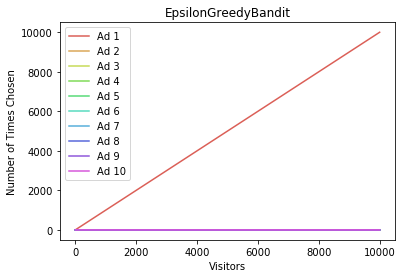

In [233]:
greedy = EpsilonGreedyBandit(ads, epsilon=0, random_state=SEED)
simulate_bandit(greedy, ads, dataset)

<h1>E-Greedy methods</h1>

<h3>Exploiting with epsilon=0.2</h3>

Total rewards = 2396


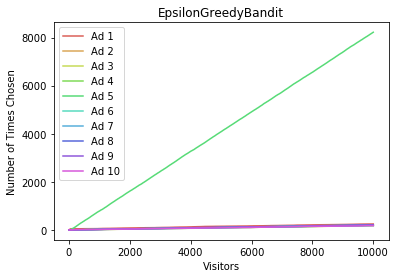

In [163]:
Egreedy = EpsilonGreedyBandit(ads, epsilon=0.2, random_state=SEED)
simulate_bandit(Egreedy, ads, dataset)

<h3>Exploiting with epsilon=0.3</h3>

Total rewards = 2254


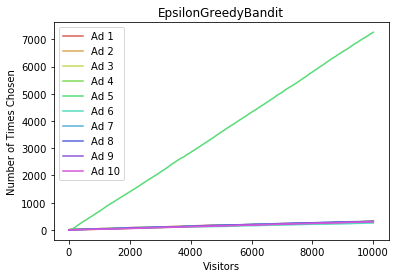

In [161]:
Egreedy = EpsilonGreedyBandit(ads, epsilon=0.3, random_state=SEED)
simulate_bandit(Egreedy, ads, dataset)

<h3>Exploiting without epsilon=0.4</h3>

Total rewards = 2098


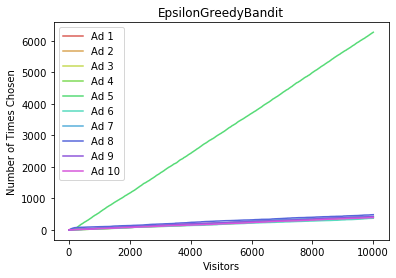

In [165]:
Egreedy = EpsilonGreedyBandit(ads, epsilon=0.4, random_state=SEED)
simulate_bandit(Egreedy, ads, dataset)

<h1>Exploring for the first 1500,2000,3700, and 5000 time steps</h1>

<h3>Exploring for the first 1500 trials; Epsilon=0.2</h3>

Total rewards = 2656


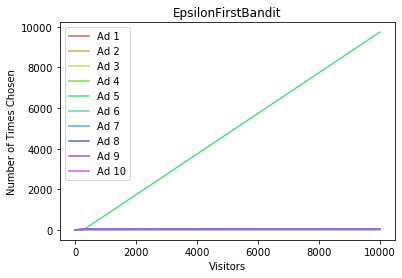

In [219]:
trials_bandit = EpsilonFirstBandit(ads, epsilon=0.2, trials=1500, random_state=SEED)
simulate_bandit(trials_bandit, ads, dataset)

<h3>Exploring for the first 2000 trials; Epsilon=0.2</h3>

Total rewards = 2639


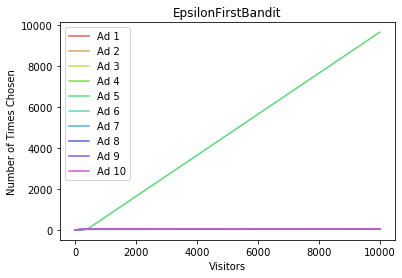

In [220]:
trials_bandit = EpsilonFirstBandit(ads, epsilon=0.2, trials=2000, random_state=SEED)
simulate_bandit(trials_bandit, ads, dataset)

<h3>Exploring for the first 3700 trials; Epsilon=0.2</h3>

Total rewards = 2579


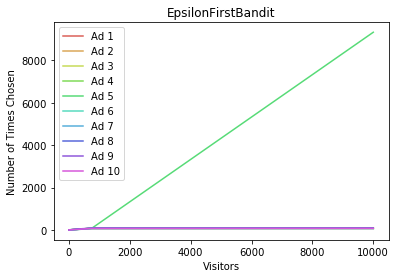

In [166]:
trials_bandit = EpsilonFirstBandit(ads, epsilon=0.2, trials=3700, random_state=SEED)
simulate_bandit(trials_bandit, ads, dataset)

<h3>Exploring for the first 5000 trials; Epsilon=0.2</h3>

Total rewards = 2547


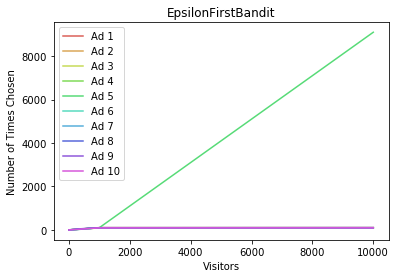

In [169]:
trials_bandit = EpsilonFirstBandit(ads, epsilon=0.2, trials=5000, random_state=SEED)
simulate_bandit(trials_bandit, ads, dataset)

<h1>Decaying exploration rate</h1>

<h3>Decaying exploration rate; Epsilon=0.3; decay=7</h3>

Total rewards = 1703


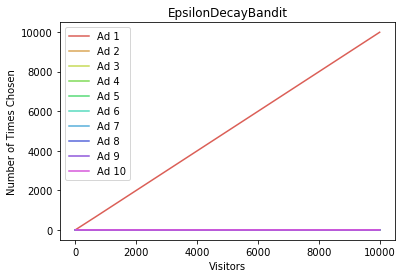

In [167]:
Edecay = EpsilonDecayBandit(ads, epsilon=0.3, decay=7, random_state=SEED)
simulate_bandit(Edecay, ads, dataset)

<h3>Decaying exploration rate; Epsilon=0.3; decay=5</h3>

Total rewards = 1703


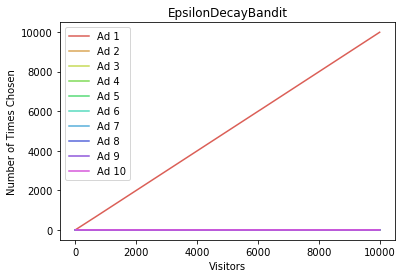

In [221]:
Edecay = EpsilonDecayBandit(ads, epsilon=0.3, decay=5, random_state=SEED)
simulate_bandit(Edecay, ads, dataset)

<h1>UCB Bandit</h1>

Total rewards = 2321


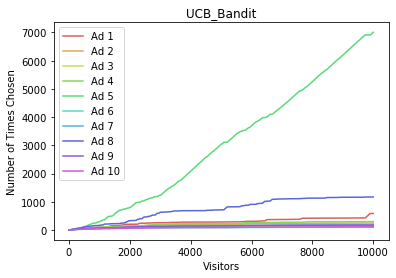

In [217]:
ucb = UCB_Bandit(ads, random_state=SEED)
simulate_bandit(ucb, ads, dataset)